In [ ]:
#!pip install --quiet tqdm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

In [5]:
pwd

'/home/jovyan/capstone-52/topic_modeling_experiments/classifiers'

In [6]:
cd ../../../capstone-52/Pickled_from_mongo/

/home/jovyan/capstone-52/Pickled_from_mongo


In [7]:
df = pd.read_pickle('../Pickled_from_mongo/combined_eg_gulf_300k_sample.p')

In [8]:
df = df.drop(['_id', 'cleaned_geo', 'cleaned_name'], axis=1)

In [9]:
df.shape

(302938, 2)

In [10]:
df.head()

,cleaned_text,class
0,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG
1,هي آراء آه بس أزاي أجويرو منتهي يعني أمال لو م...,EG
2,أنت صيني أزاي تقارن شادي بالخطيب ألي هو الوحيد...,EG
3,أزاي الناس كانت بتغرد في الخمسينات قبل إختراع ...,EG
4,التوينز اللي معاها كل الحلو والوحش والمصايب وا...,EG


In [11]:
stop_words_df = pd.read_pickle('/home/jovyan/capstone-52/topic_modeling_experiments/pickled_stopwords/comp_study_stopwords.p')

In [12]:
stop_words_df.columns = ["stop_words"]

In [13]:
iabuelkhair_stopwords = stop_words_df['stop_words'].tolist()

In [14]:
iabuelkhair_stopwords[:7]

['انها', 'اثناء', 'اجل', 'احدا', 'احدى', 'احيانا', 'اخرى']

## Label Encode the Classes

In [15]:
le = LabelEncoder()
df['class_numerical'] = le.fit_transform(df['class'])

## Ridge Classifier

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['class_numerical'], random_state = 42)

In [76]:
X_test.shape, y_test.shape

((75735,), (75735,))

In [17]:
X_train.iloc[8]

'يارب أيام جميله وأخبار مفرحه وشعور جمّيل ونفس مقتنعه وقلب مرتاح وراحة بال وتوفيق من عندك'

In [19]:
params = [(ngr, mindf, maxdf, alpha)
          for ngr in [(1,2)]
          for mindf in [1,8]
          for maxdf in np.linspace(.95,.999,1)
          for alpha in np.logspace(-1,3,1)
         ]

skfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

results_list = []

for ngr, mindf, maxdf, alpha in tqdm(params):
    results = {
        'ngram_range' : ngr,
        'min_df' : mindf,
        'max_df' : maxdf,
        'alpha' : alpha
    }
    train_scores = list()
    val_scores = list()
    
    for train_indices, val_indices in skfold.split(X_train.astype('str'), y_train):
        
        X_train_kf, y_train_kf = X_train.iloc[train_indices], y_train.iloc[train_indices]
        X_val_kf, y_val_kf = X_train.iloc[val_indices], y_train.iloc[val_indices]
        
        ridge_clf_pipe = Pipeline([
                                ('tfidf', TfidfVectorizer(ngram_range=ngr, min_df=mindf, max_df=maxdf, stop_words=iabuelkhair_stopwords)),
                                ('svd', TruncatedSVD(50)),
                                ('clf', RidgeClassifier(alpha=alpha))
                            ])
        
        ridge_clf_pipe.fit(X_train_kf, y_train_kf)
        
        train_scores.append(ridge_clf_pipe.score(X_train_kf, y_train_kf))
        val_scores.append(ridge_clf_pipe.score(X_val_kf, y_val_kf))
        
    results['mean_train_score'] = np.mean(train_scores)
    results['mean_val_score'] = np.mean(val_scores)
    results_list.append(results)

cv_results = pd.DataFrame(results_list)

cv_results.sort_values('mean_val_score', ascending=False, inplace=True)

alpha, maxdf, _, _, mindf, ngr = cv_results.iloc[0].values

cv_results.head()

100%|██████████| 2/2 [01:54<00:00, 57.22s/it]


,alpha,max_df,mean_train_score,mean_val_score,min_df,ngram_range
0,0.1,0.95,0.724946,0.730444,1,"(1, 2)"
1,0.1,0.95,0.726144,0.726073,8,"(1, 2)"


In [20]:
ridge_clf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=ngr, min_df=mindf, max_df=maxdf)),
                        ('svd', TruncatedSVD(100)),
                        ('clf', RidgeClassifier(alpha=alpha))
                    ])

ridge_clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.94999999999999996, max_features=None,
        min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
  ...tercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001))])

In [21]:
ridge_clf_pipe.score(X_train, y_train)

0.77131463933134681

In [22]:
ridge_clf_pipe.score(X_test, y_test)

0.77231134878193697

In [23]:
print(classification_report(y_train, ridge_clf_pipe.predict(X_train)))
print(classification_report(y_test, ridge_clf_pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.87      0.64      0.74    113713
          1       0.71      0.90      0.80    113490

avg / total       0.79      0.77      0.77    227203

             precision    recall  f1-score   support

          0       0.85      0.66      0.75     37959
          1       0.72      0.88      0.79     37776

avg / total       0.79      0.77      0.77     75735



In [24]:
ridge_clf_predictions = ridge_clf_pipe.predict(X_test)

In [25]:
confmat = confusion_matrix(y_test, ridge_clf_predictions)

print(confmat)

[[25215 12744]
 [ 4500 33276]]


In [26]:
fpr, tpr, thresholds = roc_curve(y_train, ridge_clf_pipe.predict(X_train)[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

IndexError: too many indices for array

## SGD Classifier

In [27]:
sgd_clf_pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                           alpha=1e-3, random_state=42)),
                    ])

sgd_clf_pipe.fit(X_train, y_train)  

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [28]:
x_test_pred_proba = sgd_clf_pipe.predict_proba(X_test)

In [53]:
x_test_pred_proba.shape

(75735, 2)

In [66]:
x_test_pred_proba[:20][:]

array([[ 0.30497802,  0.69502198],
       [ 0.51729151,  0.48270849],
       [ 0.6026077 ,  0.3973923 ],
       [ 1.        ,  0.        ],
       [ 0.71865368,  0.28134632],
       [ 0.30350169,  0.69649831],
       [ 0.40731289,  0.59268711],
       [ 0.814715  ,  0.185285  ],
       [ 0.2443479 ,  0.7556521 ],
       [ 0.34312663,  0.65687337],
       [ 0.90977628,  0.09022372],
       [ 0.62332927,  0.37667073],
       [ 0.63578383,  0.36421617],
       [ 0.16200711,  0.83799289],
       [ 0.68231089,  0.31768911],
       [ 1.        ,  0.        ],
       [ 0.309177  ,  0.690823  ],
       [ 0.26203173,  0.73796827],
       [ 0.68715109,  0.31284891],
       [ 0.50708775,  0.49291225]])

In [31]:
X_test_preds_thresh_45 = x_test_pred_proba[:,0] < .45

In [32]:
X_test_preds_thresh_45[:5]

array([ True, False, False, False, False], dtype=bool)

In [33]:
X_test_preds_thresh_45[:5].astype(int)

array([1, 0, 0, 0, 0])

In [34]:
y_test[:5]

46436     1
104133    1
45173     0
12190     0
17651     0
Name: class_numerical, dtype: int64

In [35]:
print(classification_report(y_test, x_test_pred_proba[:,0]<.33))

             precision    recall  f1-score   support

          0       0.62      0.97      0.75     37959
          1       0.92      0.40      0.56     37776

avg / total       0.77      0.68      0.66     75735



In [36]:
confmat = confusion_matrix(y_test, x_test_pred_proba[:,0]<.33)

print(confmat)

[[36680  1279]
 [22578 15198]]


In [69]:
#absolute diff bet x preds 
wrong_mask = ((x_test_pred_proba[:,0]>.4)&(x_test_pred_proba[:,0]<.6))

In [72]:
wrong_mask[:20]

array([False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True], dtype=bool)

In [70]:
X_test[wrong_mask]

104133                                           اتفق والله
62408                             شدراك اني لابسه جاكيت جلد
42803             لولا الحياه كان تحملت كل مشقاتج بس مايصير
42841                                     الساكت بيرغى جواه
45243                                            بدعي والله
111334            حلوه ترددها كل كلمة تخرج م بين شفاتي حلوة
3666                                   صباح جميل يسعد صباحك
10971     من سار بين الناس جابراً للخواطر أدركه الله فى ...
92953                  أه و السواقين ينبهوا بعض بالتيكستينج
8266      فاهم الموضوع غلط 🤦‍️ لما تجرب كل المفاتيح بعدي...
52693                                 يارب يطلع التزوير كذب
121234    كدهووو لوحديييي كدهوو من غير اي مجهود بصحي الص...
58761            بتبقى سرّي الحلُو بتبقى المقصود بكُل الحكي
76195     يختي حبي وغازلي وان شاءالله وانتي نايمه كمان ب...
10964     نعلم ويعلم حكماء الخليج بأن يا الإعتراف بإسرائ...
116813                       طيب التشهير بعين وحدة واصباعين
3318      متى أقول مسافة دمعتين و أوصل ي

In [59]:
wrong_mask.sum()

39693

In [37]:
wrong_mask = y_test != (x_test_pred_proba[:,0]<.45).astype(int)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302938 entries, 0 to 151265
Data columns (total 3 columns):
cleaned_text       302938 non-null object
class              302938 non-null object
class_numerical    302938 non-null int64
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [42]:
(x_test_pred_proba[:,0]<.45).astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [44]:
confidence_mask = (x_test_pred_proba[:,0]<.1)|(x_test_pred_proba[:,0]>.6)

In [45]:
x_test_pred_proba[confidence_mask, 0]

array([ 0.6026077 ,  1.        ,  0.71865368, ...,  0.79208586,
        0.8136766 ,  0.85128754])

In [46]:
print(classification_report(y_test[confidence_mask], x_test_pred_proba[confidence_mask,0] < .6))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     21160
          1       0.95      0.46      0.62      1662

avg / total       0.96      0.96      0.95     22822



In [47]:
confidence_mask

array([False, False,  True, ...,  True, False, False], dtype=bool)

In [44]:
def predict(model, X, threshold):
    proba = model.predict_proba(X)
    return proba[:,0] < threshold

In [48]:
sgd_clf_pipe.score(X_train, y_train)

0.82210182083863326

In [49]:
sgd_clf_pipe.score(X_test, y_test)

0.81857793622499508

In [50]:
print(classification_report(y_train, sgd_clf_pipe.predict(X_train)))
print(classification_report(y_test, sgd_clf_pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      0.71      0.80    113713
          1       0.76      0.93      0.84    113490

avg / total       0.84      0.82      0.82    227203

             precision    recall  f1-score   support

          0       0.90      0.71      0.80     37959
          1       0.76      0.92      0.84     37776

avg / total       0.83      0.82      0.82     75735



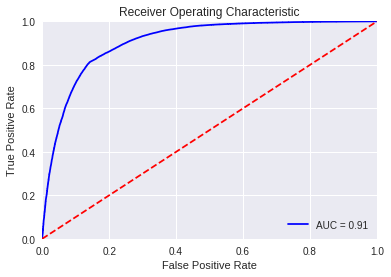

In [42]:
# calculate the fpr and tpr for all thresholds of the classification
probs = x_test_pred_proba
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## MultinomialNB

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['cleaned_text'])
X_train_counts.shape

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
multinomialnb_clf = MultinomialNB().fit(X_train_tfidf, df['class'])

In [ ]:
 df['class'][:4]

In [ ]:
multinomialnb_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])

In [ ]:
multinomialnb_clf.fit(df['cleaned_text'], df['class'])

In [ ]:
print(classification_report(y_train, multinomialnb_clf.predict(X_train)))
print(classification_report(y_test, multinomialnb_clf.predict(X_test)))

## KNN

In [1]:
lsi = models.LsiModel.load('../topic_modeling_experiments/lsa_lda/model_lsi.pkl')

NameError: name 'models' is not defined

In [ ]:
corpus_lsi = lsi[corpus_tfidf]

In [ ]:
lsa_clf_pipe = Pipeline([
                        ('lsi', corpus_lsi),
                        ('clf', RidgeClassifier())
                    ])

ridge_clf_pipe.fit(X_train, y_train)

In [ ]:
(KNeighborsClassifier(n_neighbors=10), "kNN")

In [86]:
ridge_clf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=[(1,2)], min_df=1, stop_words= [iabuelkhair_stopwords], max_df=0.7),
                        ('svd', TruncatedSVD(100)),
                        ('clf', RidgeClassifier()))
                    ])

ridge_clf_pipe.fit(X_train, y_train)

ValueError: too many values to unpack (expected 2)

In [ ]:
from scipy.stats import norm

In [ ]:
norm.pdf()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = x_test_pred_proba, y_train


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [74]:
from sklearn.linear_model import LinearRegression

In [77]:
lin_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lin', LinearRegression(fit_intercept=True, normalize=True)
                      )])

In [78]:

lin_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...se_idf=True)), ('lin', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [79]:
type(lin_clf)

sklearn.pipeline.Pipeline

In [84]:
# plot data and decision surface
ax = plt.gca()
ax.scatter(X_train, y_train)
try:
    plot_surface(lin_clf, lin_clf.predict_proba[:, 0], lin_clf.predict_proba[:, 1], ax=ax)
except NameError:
    print('Please run cells in Appendix first')

ValueError: could not convert string to float: 'يا رب انت عارف اللي فيها والله انا تعبت'

ValueError: could not convert string to float: 'يا رب انت عارف اللي فيها والله انا تعبت'

In [73]:

est = LinearRegression().fit(X_train, y_train)

# test on data that was not used for fitting
y_pred = (2 * (est.predict(X) > 0.0)) - 1

confusion_matrix(y_test, y_pred)

NameError: name 'LinearRegression' is not defined

In [ ]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()